In [1]:

# Import necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import string
import requests
from bs4 import BeautifulSoup
import re

import os

import sys
from IPython.display import display, HTML
import urllib
import gzip

import nltk
from nltk import tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import pip

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [2]:
def cleaning(s):
    
    s = str(s)
    #s = str.split(s)
    s = s.lower()
    s = re.sub('\s\W',' ',s)
    s = re.sub('\W,\s',' ',s)
    s = re.sub(r'[^\w]', ' ', s)
    s = re.sub("\d+", "", s)
    s = re.sub('\s+',' ',s)
    s = re.sub('[!@#$_]', '', s)
    s = s.replace(",","")
    s = s.replace("[\w*"," ")
    s = re.sub(r'https?:\/\/.*[\r\n]*', '', s, flags=re.MULTILINE)
    s = re.sub(r'\<a href', ' ', s)
    s = re.sub(r'&amp;', '', s) 
    s = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', s)
    s = re.sub(r'[^\x00-\x7f]',r'',s) #removes arabic
    s = re.sub(r'<br />', ' ', s)
    s = re.sub(r'\'', ' ', s)
    
    return s

train['Text'] = [cleaning(s) for s in train['Text']]


NameError: name 'train' is not defined

In [14]:
train

,Topic_Code,Category,Text,Code
index,,,,
155,AASKK211,10,understand boxplot outlier,10
3,AASKK237,16,calculate mean median mode function python,16
178,AASKK34,0,key dictionary,0
29,AASKK78,3,different arithmatic operator available python,3
98,AASKK319,8,utilize panda dataframe,8
...,...,...,...,...
141,AASKK06,11,python general purpose,11
69,AASKK17,18,tuples,18
38,AASKK180,2,aggregation panda groupby,2


In [2]:
def cleanString(review,stopWords):
    lemmatizer = WordNetLemmatizer()
    nonan = re.compile(r'[^a-zA-Z ]')
    returnString = ""
    sentence_token = tokenize.word_tokenize(review)
    idx_list = []
    for j in range(len(sentence_token)):
        single_sentence = nonan.sub('', sentence_token[j])
        single_sentence = tokenize.word_tokenize(sentence_token[j])
        single_sentence=[lemmatizer.lemmatize(t) for t in single_sentence]
        single_sentence=[word for word in single_sentence if word.lower() not in stopWords]
        sentences_filtered = [(idx,lemmatizer.lemmatize(w.lower())) for idx,w in enumerate(single_sentence) 
                              if w.lower() not in stopWords and w.isalnum()]
        idx_list.append([x[0] for x in sentences_filtered])
        word_list = [x[1] for x in sentences_filtered]
        returnString = returnString + ' '.join(word_list) + ' '
    
    return returnString, idx_list



In [11]:
def split_df(dataframe, column_name, training_split = 0.6, validation_split = 0.2, test_split = 0.2):
    """
    Splits a pandas dataframe into trainingset, validationset and testset in specified ratio.
    All sets are balanced, which means they have the same ratio for each categorie as the full set.
    Input:   dataframe        - Pandas Dataframe, should include a column for data and one for categories
             column_name      - Name of dataframe column which contains the categorical output values
             training_split   - from ]0,1[, default = 0.6
             validation_split - from ]0,1[, default = 0.2        
             test_split       - from ]0,1[, default = 0.2
                                Sum of all splits need to be 1
    Output:  train            - Pandas DataFrame of trainset
             validation       - Pandas DataFrame of validationset
             test             - Pandas DataFrame of testset
    """
    if training_split + validation_split + test_split != 1.0:
        raise ValueError('Split paramter sum should be 1.0')
        
    total = len(dataframe.index)
 
    train = dataframe.reset_index().groupby(column_name).apply(lambda x: x.sample(frac=training_split))\
    .reset_index(drop=True).set_index('index')
    train = train.sample(frac=1)
    temp_df = dataframe.drop(train.index)
    validation = temp_df.reset_index().groupby(column_name)\
    .apply(lambda x: x.sample(frac=validation_split/(test_split+validation_split)))\
           .reset_index(drop=True).set_index('index')
    validation = validation.sample(frac=1)
    test = temp_df.drop(validation.index)
    test = test.sample(frac=1)
    
    print('Total: ', len(dataframe))
    print('Training: ', len(train), ', Percentage: ', len(train)/len(dataframe))
    print('Validation: ', len(validation), ', Percentage: ', len(validation)/len(dataframe))
    print('Test:', len(test), ', Percentage: ', len(test)/len(dataframe))

    return train, validation, test

In [12]:
def get_vec_pipe(vectorizer_tfidf,num_comp=0, reducer='svd'):  
 
    # Vectorizer
    vec_pipe = [
       #('col_extr', JsonFields(0, ['title', 'body', 'url'])),
       #('squash', Squash()),
       ('vec', vectorizer_tfidf)
    ]

    # Reduce dimensions of tfidf
    if num_comp > 0:
        if reducer == 'svd':
            vec_pipe.append(('dim_red', TruncatedSVD(num_comp)))

        vec_pipe.append(('norm', Normalizer()))

    return Pipeline(vec_pipe)

In [3]:
import csv
import numpy as np
import string
import re
from sklearn.metrics import classification_report,confusion_matrix
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet, stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from yellowbrick.classifier import ConfusionMatrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

C:\Users\KarthikeyanNatarajan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk.stem
english_stemmer = nltk.stem.SnowballStemmer('english')
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer,self).build_analyzer()
        return lambda doc:(english_stemmer.stem(word) for word in analyzer(doc))
    
class StemmedCountVectorizer(CountVectorizer):
    def __init__(self, stemmer):
        super(StemmedCountVectorizer, self).__init__()

    def build_analyzer(self):
        analyzer = super(CountVectorizer, self).build_analyzer()
        return lambda doc:(english_stemmer.stem(word) for word in analyzer(doc))

In [6]:
def tokenize_test(model,train,validation,num_comp,class1):
    from sklearn.decomposition import NMF
    from sklearn.preprocessing import Normalizer
    lsa = TruncatedSVD(n_components=200)
    X_test1 = char_vectorizer.transform(validation)
    X_test2 = word_vectorizer.transform(validation)
    test_stack = hstack([X_test1,X_test2])
    #train_text = vect.fit_transform(train["Text"])
    #print ('Features: ', train_text.shape[1])
    #test_text = vect.transform(validation["Text"])
   
    tsvd=TruncatedSVD(num_comp)
    train_features1 = tsvd.fit_transform(train_features)
    test_stack = tsvd.transform(test_stack)

    train_features1 = Normalizer(copy=False).fit_transform(train_features1)
    test_stack = Normalizer(copy=False).transform(test_stack)
    model.fit(train_features1, y_train)
    y_pred_class = model.predict(test_stack)
    
    print("Training Accuracy")
    print(model.score(train_features1,y_train))
    print("Testing Accuracy")
    print(model.score(test_stack,y_test))
    print(classification_report(y_pred_class,y_test))
    cm = ConfusionMatrix(model, classes=class1)



#To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
#and then creates the confusion_matrix from scikit learn.
    cm.score(test_stack, validation["Code"])

#How did we do?
    cm.poof()
    #print(confusion_matrix(y_pred_class,validation["Code"]))


####################ACTUAL CODE STARTS FROM HERE

In [51]:
stats=pd.read_excel('Supervised Learning-Chatbot.xlsx',encoding =  "ISO-8859-1")
from sklearn.preprocessing import LabelEncoder
stats.columns=["a","Question","Sub_Topic_Code"]
labelEncoder = LabelEncoder()
stats["Sub_Topic_Code"] = labelEncoder.fit_transform(stats["Sub_Topic_Code"])
stats = stats.rename(columns={'Sub_Topic_Code': 'Category', 'Question': 'Text'})
data_df=stats.sample(frac=1).reset_index(drop=True)

In [23]:
def cleanData(string1):
    articles = []
    n = 1

    stopWords = set(stopwords.words('english'))
    for i in range(n):
        temp_string,idx_string = cleanString(string1,stopWords)
        articles.append(temp_string)
        print(str(i+1)+' of '+str(n)+" articles cleaned.",end='\r')
    
    return(articles)

In [52]:
data_df

,a,Text,Category
0,AASKK11,What is Feature scaling ?,0
1,AASKK27,What is Gradient descent ?,1
2,AASKK22,What is KNN algorithm ?,1
3,AASKK19,What is Naïve bayes algorithm ?,0
4,AASKK29,What is F1 score ?,1
5,AASKK28,What is Cost Function ?,0
6,AASKK18,What is Logistic Regression ?,0
7,AASKK51,What is Standadization ?,2
8,AASKK10,What is Feature Selection ?,0
9,AASKK42,What is Toatal error or SST ?,1


In [53]:
def clean_data(data_df):
    articles = []
    n = data_df['Text'].shape[0]
    col_number = data_df.columns.get_loc('Text')
    stopWords = set(stopwords.words('english'))
    data_cleaned = data_df.copy()
    for i in range(n):
        temp_string,idx_string = cleanString(data_df.iloc[i,col_number],stopWords)
        articles.append(temp_string)
        print(str(i+1)+' of '+str(n)+" articles cleaned.",end='\r')
    
    data_cleaned.loc[:,'Text'] = pd.Series(articles,index=data_df.index)
    data_cleaned.loc[:,'Category'] = pd.Categorical(data_cleaned.Category)
    data_cleaned['Code'] = data_cleaned.Category.cat.codes
    categoryToCode = dict( enumerate(data_cleaned['Category'].cat.categories))
    return(data_cleaned)
data_cleaned=clean_data(data_df)
from sklearn.model_selection import train_test_split
y=data_cleaned["Code"]
X=data_cleaned["Text"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=23, stratify=y)

In [11]:
def cleanData(string1):
    articles = []
    n = 1

    stopWords = set(stopwords.words('english'))
    for i in range(n):
        temp_string,idx_string = cleanString(string1,stopWords)
        articles.append(temp_string)
        print(str(i+1)+' of '+str(n)+" articles cleaned.",end='\r')
    
    return(articles)

In [101]:
train, validation, test = split_df(data_cleaned, 'Code',0.8,0.20,0)

Total:  163
Training:  130 , Percentage:  0.7975460122699386
Validation:  33 , Percentage:  0.20245398773006135
Test: 0 , Percentage:  0.0


In [54]:
import re

from sklearn.pipeline import Pipeline 
def build_tokenizer(doc):
    token_pattern=r"(?u)\b\w+"
    token_pattern = re.compile(token_pattern)
    return token_pattern.findall(doc)
posts_root1=[]
for post in X_train:
    #print build_tokenizer(post)
    #print " ".join([english_stemmer.stem(word) for word in build_tokenizer(post)])
    a=" ".join([english_stemmer.stem(word) for word in build_tokenizer(post)])
    posts_root1.append(a)

word_vectorizer = StemmedTfidfVectorizer(
    sublinear_tf=True,
    stop_words = 'english',
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1,3),
    dtype=np.float32,
    max_features=8000,
    
)
# Character Stemmer
char_vectorizer = StemmedTfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(1, 6),
    dtype=np.float32,
    max_features=8000,
   
)



word_vectorizer.fit(posts_root1)
char_vectorizer.fit(posts_root1)

train_word_features = word_vectorizer.transform(posts_root1)
train_char_features = char_vectorizer.transform(posts_root1)

from scipy.sparse import hstack
train_features = hstack([
    train_char_features,
    train_word_features])

import pickle
filename = 'char_preprocessing.sav'
pickle.dump(word_vectorizer, open(filename, 'wb'))
filename = 'word_preprocessing.sav'
pickle.dump(char_vectorizer, open(filename, 'wb'))
print("feature_name:%s" % len(char_vectorizer.get_feature_names()))


feature_name:1527


In [28]:
def tokenize_test2(model,train,text,class1):
    from sklearn.decomposition import NMF
    from sklearn.preprocessing import Normalizer
    print(text)
    X_test1 = char_vectorizer.transform(text)
    X_test2 = word_vectorizer.transform(text)
    test_stack = hstack([X_test1,X_test2])
    #\train_text = lsa.fit_transform(X_train_dtm)
    #test_text = lsa.fit_transform(X_test_dtm)
    train_features1 = Normalizer(copy=False).fit_transform(train_features)
    test_stack = Normalizer(copy=False).transform(test_stack)
    model.fit(train_features.todense(), train["Code"])
    filename = 'model.sav'
    pickle.dump(model, open(filename, 'wb'))
    y_pred_class = model.predict(test_stack)
    print(y_pred_class)

In [35]:
def tokenize_test3(text):
    print(text)
    clntxt=cleanData("how to close a file automatically when you use")
    print("\n")
    word_model = pickle.load( open( "word_preprocessing.sav", "rb" ) )
    char_model = pickle.load( open( "char_preprocessing.sav", "rb" ) )
    X_test1 = word_model.transform(clntxt)
    X_test2 = char_model.transform(clntxt)
    test_stack = hstack([X_test1,X_test2])
    model = pickle.load( open( "model.sav", "rb" ) )
    y_pred_class = model.predict(test_stack)
    print(y_pred_class)

In [36]:
tokenize_test3("how to close a file automatically when you use")

how to close a file automatically when you use
1 of 1 articles cleaned.

[1]


Training Accuracy
1.0
Testing Accuracy
0.45454545454545453
              precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.50      0.50      0.50         4
           2       0.00      0.00      0.00         0

    accuracy                           0.45        11
   macro avg       0.37      0.31      0.33        11
weighted avg       0.56      0.45      0.50        11



C:\Users\KarthikeyanNatarajan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KarthikeyanNatarajan\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KeyError: 'Code'

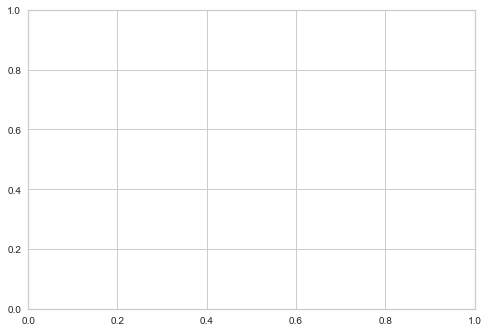

In [55]:
tokenize_test(SVC(kernel = 'linear'),X_train,X_test,500,class1=list(range(0,y.nunique())))

Training Accuracy
1.0
Testing Accuracy
0.45454545454545453
              precision    recall  f1-score   support

           0       0.60      0.50      0.55         6
           1       0.25      0.33      0.29         3
           2       0.50      0.50      0.50         2

    accuracy                           0.45        11
   macro avg       0.45      0.44      0.44        11
weighted avg       0.49      0.45      0.47        11



C:\Users\KarthikeyanNatarajan\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KeyError: 'Code'

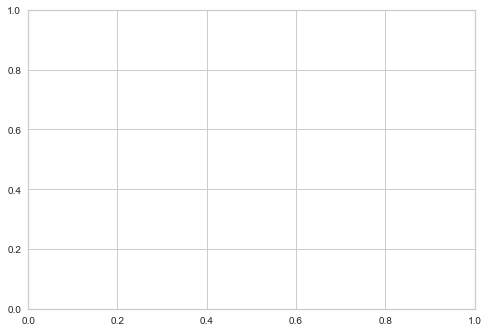

In [56]:
mlp=MLPClassifier(hidden_layer_sizes=(200, 200),activation='relu',solver = 'adam', alpha = 1e-5, learning_rate = 'adaptive', learning_rate_init = 0.005, max_iter = 500, random_state = 21)
tokenize_test(mlp,X_train,X_test,800,class1=list(range(0,X_train.nunique())))

In [15]:
SGD=SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='modified_huber',
                               max_iter=1000, n_iter_no_change=5, n_jobs=None,
                               penalty='none', power_t=0.5, random_state=None,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False)
import catboost
cls = catboost.CatBoostClassifier(loss_function='MultiClass',learning_rate=0.1, iterations=50, depth=8)
tokenize_test(cls,X_train,X_test,1500,class1=list(range(0,train["Code"].nunique())))



NameError: name 'train' is not defined

Training Accuracy
1.0
Testing Accuracy
0.9090909090909091
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.50      1.00      0.67         1
           2       1.00      1.00      1.00         1
           4       1.00      0.50      0.67         2
           6       1.00      1.00      1.00         2
           8       1.00      0.50      0.67         2
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         2
          17       1.00      1.00      1.00         3
          18       1.00      1.00      1.00         1
          19       1.00      1.00      1.00         1
          20       1.00      1.00      1.00         1

    accuracy                           0.91        22
   macro avg       0.9

C:\Users\KarthikeyanNatarajan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KarthikeyanNatarajan\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KeyError: 'Code'

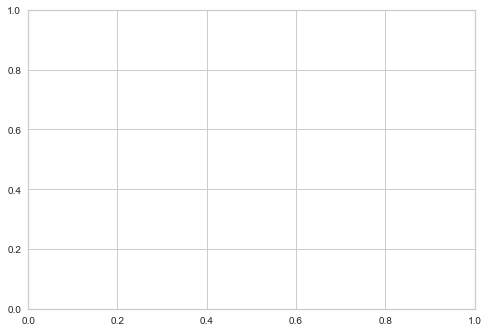

In [17]:
    from sklearn.ensemble import ExtraTreesClassifier
    SVM = SVC(kernel = 'linear', probability = False)
    from sklearn.ensemble import StackingClassifier
    from sklearn.multiclass import OneVsRestClassifier
    from lightgbm import LGBMClassifier
    from xgboost import XGBClassifier
    xgb=XGBClassifier(
     learning_rate =0.1,
     n_estimators=500,
     max_depth=15,
     min_child_weight=12,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'multi:softmax',
     nthread=16,
     scale_pos_weight=1,
     seed=9999,
     num_class= 3,
     eval_metric='merror',    # evaluation metric
     tree_method='exact',
     silent=0, 
     nthreads=-1)
    ext=ExtraTreesClassifier(n_estimators=100, 
                                                       class_weight="balanced", 
                                                       random_state=4621)

    lda=LinearDiscriminantAnalysis()
  
    EnsembleClassifier = VotingClassifier(estimators = [('sgd', ext), ('lda',lda),('svc', SVC(kernel = 'linear')),('mlp',mlp),('sgd1',SGD)], voting = 'hard', weights = [1,1,1,1,1])

    tokenize_test(EnsembleClassifier,X_train,X_test,1200,list(range(0,y.nunique())))